### Analysis on image labels

In [1]:
import os
import json
import itertools
import numpy as np
import pandas as pd
from pprint import pprint
from os.path import exists as file_exists

# Import the wordcloud library
from wordcloud import WordCloud

from ast import literal_eval

import urllib.request

import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords

import spacy

from nltk.tokenize import word_tokenize

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Draculabites\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Import Vision AI from Google Cloud
# gotta install first
# nvm failed :-( cannot get authentication

!pip install google-cloud-vision
from google.cloud import vision

parent = os.path.dirname(os.getcwd())
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = parent + "\data\service_account.json"

# def detect_labels_uri(uri):
#     """Detects labels in the file located in Google Cloud Storage or on the Web."""
#     client = vision.ImageAnnotatorClient()
#     image = vision.types.Image()
#     image.source.image_uri = uri

#     response = client.label_detection(image=image)
#     labels = response.label_annotations
#     return labels

# def extract_labels_from_gvision(url):
#     my_labels = detect_labels_uri(url)
#     my_label_list = list()
#     for label in my_labels:
#         my_label_list.append(label.description)
#     return my_label_list

# df = pd.read_csv("allposts.csv")
# df['labels'] = df['postUrl'].apply(extract_labels_from_gvision)
# df.to_csv("posts_imagelabels.csv")

You should consider upgrading via the 'c:\users\draculabites\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
parent

'C:\\Users\\Draculabites\\Desktop\\IS434 SA G2\\Project\\is434-G6-SCS'

In [4]:
df = pd.read_csv("data/allposts.csv")
df.head()

,postUrl,description,commentCount,likeCount,pubDate,likedByViewer,isSidecar,type,profileUrl,username,...,taggedFullName1,taggedUsername1,taggedFullName2,taggedUsername2,taggedFullName3,taggedUsername3,taggedFullName4,taggedUsername4,location,locationId
0,https://www.instagram.com/p/CbzXkYBsSZ0/,Happy 1st April! This means that… Our Virtual ...,0,12,2022-04-01T09:00:22.000Z,False,False,Photo,https://www.instagram.com/sgchildrensoc,sgchildrensoc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.instagram.com/p/CbhK4IQKwcd/,👀 Take a peep into #adayinthelife of a youth w...,1,36,2022-03-25T07:23:46.000Z,False,False,Video,https://www.instagram.com/sgchildrensoc,sgchildrensoc,...,GIG@JYC,jyc_at_scs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.instagram.com/p/CbeksJWrCPZ/,Singapore Children’s Society held the 1000 Ent...,0,46,2022-03-24T07:10:56.000Z,False,True,Photo,https://www.instagram.com/sgchildrensoc,sgchildrensoc,...,PARKROYAL on Beach Road,parkroyalbeachroad,Teo Chee Hean,teocheehean,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.instagram.com/p/CbeksJWrCPZ/,Singapore Children’s Society held the 1000 Ent...,0,46,2022-03-24T07:10:56.000Z,False,True,Photo,https://www.instagram.com/sgchildrensoc,sgchildrensoc,...,PARKROYAL on Beach Road,parkroyalbeachroad,Teo Chee Hean,teocheehean,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.instagram.com/p/CbeksJWrCPZ/,Singapore Children’s Society held the 1000 Ent...,0,46,2022-03-24T07:10:56.000Z,False,True,Photo,https://www.instagram.com/sgchildrensoc,sgchildrensoc,...,PARKROYAL on Beach Road,parkroyalbeachroad,Teo Chee Hean,teocheehean,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# df['urls'] = df['postUrl'] + "media/?size=l"
# df.head(3)

In [6]:
urls = list(df.imgUrl)

# For parsing into aws
with open('data/urls.json', 'w') as f:
    json.dump(urls, f)

In [7]:
# urllib.request.urlretrieve("https://www.instagram.com/p/CbZBDq6rRnv/media/?size=l", "test.jpg")

#### DONT RUN if you can't spare the time

In [8]:
# dont run this cell
# Takes around 40 minutes

# for k, url in enumerate(urls):
#     urllib.request.urlretrieve(url, f'images/postImage_{k}.jpg')

**Move over to AWS Rekognition to get**
1. **image labels** 
2. **text detection**

& then continue from this script

In [9]:
# with open(f"data/test.jpg.json") as f:
#     li = json.load(f)

# labels = [arr['Name'] for arr in li]
# labels

In [10]:
len(df)

1481

In [11]:
labels_all = []
for i in range(1, len(df) + 1):
    
    # check if file exists, i.e. no text detected
    # break out of the loop and continue from the next image
    if not file_exists(f"data/images_labels/postImage_{i}.jpg.json"):
        df.drop(i-1, inplace = True)
        continue
    fp = f"data/images_labels/postImage_{i}.jpg.json"
    with open(fp) as f:
        li = json.load(f)
        labels = [arr['Name'] for arr in li]
        labels_all.append(labels)

labels_all

[['Text', 'Letter'],
 ['Person',
  'Human',
  'Shoe',
  'Footwear',
  'Clothing',
  'Apparel',
  'Suit',
  'Coat',
  'Overcoat',
  'Crowd',
  'Fashion'],
 ['Audience',
  'Crowd',
  'Person',
  'Human',
  'Suit',
  'Coat',
  'Overcoat',
  'Clothing',
  'Apparel',
  'Speech',
  'Lecture'],
 ['Audience',
  'Crowd',
  'Person',
  'Human',
  'Room',
  'Indoors',
  'Shoe',
  'Clothing',
  'Footwear',
  'Apparel',
  'Speech',
  'Lighting',
  'Lecture',
  'Classroom',
  'School',
  'Chair',
  'Furniture',
  'Seminar'],
 ['Audience',
  'Person',
  'Crowd',
  'Human',
  'Suit',
  'Clothing',
  'Coat',
  'Overcoat',
  'Apparel',
  'Speech',
  'Lecture'],
 ['Shoe',
  'Footwear',
  'Clothing',
  'Apparel',
  'Person',
  'Human',
  'Suit',
  'Coat',
  'Overcoat',
  'Blazer',
  'Jacket',
  'People',
  'Crowd'],
 ['Person',
  'Human',
  'Canoe',
  'Rowboat',
  'Vehicle',
  'Transportation',
  'Boat',
  'Clothing',
  'Apparel',
  'Lifejacket',
  'Vest',
  'Watercraft',
  'Vessel',
  'Water'],
 ['Person

In [12]:
len(labels_all)

1480

In [13]:
df['labels'] = labels_all
# df['labels'] = df['labels'].apply(lambda x: literal_eval(x))
df["labels_str"] = df['labels'].apply(' '.join)
df = df[['postUrl','commentCount', 'likeCount', 'description', 'labels', 'labels_str']]
df.head(3)

,postUrl,commentCount,likeCount,description,labels,labels_str
0,https://www.instagram.com/p/CbzXkYBsSZ0/,0,12,Happy 1st April! This means that… Our Virtual ...,"[Text, Letter]",Text Letter
1,https://www.instagram.com/p/CbhK4IQKwcd/,1,36,👀 Take a peep into #adayinthelife of a youth w...,"[Person, Human, Shoe, Footwear, Clothing, Appa...",Person Human Shoe Footwear Clothing Apparel Su...
2,https://www.instagram.com/p/CbeksJWrCPZ/,0,46,Singapore Children’s Society held the 1000 Ent...,"[Audience, Crowd, Person, Human, Suit, Coat, O...",Audience Crowd Person Human Suit Coat Overcoat...


In [14]:
# Preprocessing on captions to make them more amenable for analysis, and reliable results. 
# RegEx to remove any punctuation, and then lowercase the text

# Remove punctuation
df['labels_str'] = df['labels_str'].str.replace(r'[^\w\s]', '')

# Convert to lowercase
df['labels_str'] = df['labels_str'].str.lower()

# Replace null values (no caption) with 'null'
df['labels_str'].fillna('null', inplace = True)

# Print out the first rows of papers
df['labels_str'].head()

C:\Users\Draculabites\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


0                                          text letter
1    person human shoe footwear clothing apparel su...
2    audience crowd person human suit coat overcoat...
3    audience crowd person human room indoors shoe ...
4    audience person crowd human suit clothing coat...
Name: labels_str, dtype: object

### What topics are more related to engagement?

Create a metric for engagement by using a weighted sum of # likes and # comments. 

To create an engagement score, use 0.4# likes (normalized) + 0.6# comments (normalized). Define High (1) and Low (0) engagement based on whether the engagement score is above or below the median value.

In [15]:
# normalize # likes and # comments such that they both have values between 0 and 1
# scale the # likes by dividing by the maximum # likes (for a post) an # comments

df["likes_normalized"] = df["likeCount"]/df["likeCount"].max() 
df["comments_normalized"] = df["commentCount"]/df["commentCount"].max()

## Create engagement score
df["engagement_score"] = 0.4 * df["likes_normalized"] + 0.6 * df["comments_normalized"]

engagement_median = df["engagement_score"].median()
df["engagement"] = df["engagement_score"].apply(lambda x: 1 if x > engagement_median else 0)
df.head(3)

,postUrl,commentCount,likeCount,description,labels,labels_str,likes_normalized,comments_normalized,engagement_score,engagement
0,https://www.instagram.com/p/CbzXkYBsSZ0/,0,12,Happy 1st April! This means that… Our Virtual ...,"[Text, Letter]",text letter,0.022642,0.000000,0.009057,0
1,https://www.instagram.com/p/CbhK4IQKwcd/,1,36,👀 Take a peep into #adayinthelife of a youth w...,"[Person, Human, Shoe, Footwear, Clothing, Appa...",person human shoe footwear clothing apparel su...,0.067925,0.033333,0.047170,1
2,https://www.instagram.com/p/CbeksJWrCPZ/,0,46,Singapore Children’s Society held the 1000 Ent...,"[Audience, Crowd, Person, Human, Suit, Coat, O...",audience crowd person human suit coat overcoat...,0.086792,0.000000,0.034717,1


### Topic modeling (LDA) on the image labels. 

Output:
1. A file showing which words load on which topics
2. A file showing topic weights for each image.

Now take the quartiles with highest and lowest engagement scores. What are the differences in the average topic weights of pictures across the two quartiles (e.g., greater proportion of some topics in highest engagement quartile)? Show the main results in a table.

In [16]:
# EDA to transfrom caption into inputs for LDA 
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'us', 'like', 'also', 'society', 'societies', 'sgchildren', 
                   'sgchild', 'sgchildrens', 'sgchildrensoc', 'childrens', 'children', 'childs', 'child', 'singapore', 'social', 
                   'youth', 'help', 'support', 'link', 'bio', 'need', 'ms', 'please', 'day', 'today'])

def to_words(sentences):
    for sentence in sentences:
        # deacc = True removes punctuations
        yield(simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word.lower() not in stop_words] for doc in texts]

data_words = list(to_words(list(df['labels_str'])))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words)
df['tokens'] = data_words

[['text', 'letter'], ['person', 'human', 'shoe', 'footwear', 'clothing', 'apparel', 'suit', 'coat', 'overcoat', 'crowd', 'fashion'], ['audience', 'crowd', 'person', 'human', 'suit', 'coat', 'overcoat', 'clothing', 'apparel', 'speech', 'lecture'], ['audience', 'crowd', 'person', 'human', 'room', 'indoors', 'shoe', 'clothing', 'footwear', 'apparel', 'speech', 'lighting', 'lecture', 'classroom', 'school', 'chair', 'furniture', 'seminar'], ['audience', 'person', 'crowd', 'human', 'suit', 'clothing', 'coat', 'overcoat', 'apparel', 'speech', 'lecture'], ['shoe', 'footwear', 'clothing', 'apparel', 'person', 'human', 'suit', 'coat', 'overcoat', 'blazer', 'jacket', 'people', 'crowd'], ['person', 'human', 'canoe', 'rowboat', 'vehicle', 'transportation', 'boat', 'clothing', 'apparel', 'lifejacket', 'vest', 'watercraft', 'vessel', 'water'], ['person', 'human', 'toy', 'monitor', 'electronics', 'screen', 'display'], ['person', 'human', 'jeans', 'denim', 'pants', 'clothing', 'apparel', 'shoe', 'footw

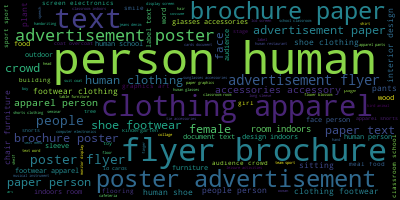

In [17]:
def create_cloud(data):
    text = ','.join(data)

    # Create a WordCloud object
    wordcloud = WordCloud(background_color="black", max_words=5000, contour_width=3, contour_color='steelblue')

    # Generate a word cloud
    wordcloud.generate(text)
    
    return wordcloud

processed = list(itertools.chain(*data_words))

wordcloud = create_cloud(processed)
# Visualize the word cloud
wordcloud.to_image()

In [18]:
def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

def get_corpus(df):
    """
    Get Bigram Model, Corpus, id2word mapping
    """
    bigram = bigrams(df['tokens'])
    bigram = [bigram[review] for review in df['tokens']]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

train_corpus, train_id2word, bigram_train = get_corpus(df)

In [19]:
import logging
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus,
                           num_topics=5,
                           id2word=train_id2word,
                           chunksize=100,
                           workers=7, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)
    lda_train.save('results/topic_modelling_images/lda_train.model')

In [20]:
coherence_model_lda = CoherenceModel(model=lda_train, texts=bigram_train, dictionary=train_id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("The coherence of the LDA model is", coherence_lda)

The coherence of the LDA model is 0.4749766089102156


In [53]:
pprint(lda_train.print_topics())

[(0,
  '0.111*"indoors" + 0.105*"room" + 0.092*"crowd" + 0.061*"school" + '
  '0.056*"screen" + 0.051*"electronics" + 0.051*"furniture" + 0.045*"audience" '
  '+ 0.044*"classroom" + 0.042*"table"'),
 (1,
  '0.093*"clothing" + 0.091*"apparel" + 0.053*"outdoors" + 0.049*"shoe" + '
  '0.044*"footwear" + 0.034*"accessories_accessory" + 0.033*"phone" + '
  '0.030*"building" + 0.030*"nature" + 0.029*"animal"'),
 (2,
  '0.179*"advertisement" + 0.177*"poster" + 0.162*"paper" + 0.148*"flyer" + '
  '0.147*"brochure" + 0.085*"text" + 0.014*"document" + 0.013*"collage" + '
  '0.009*"graphics_art" + 0.009*"bag"'),
 (3,
  '0.194*"clothing" + 0.192*"apparel" + 0.119*"people" + 0.072*"face" + '
  '0.068*"female" + 0.051*"shoe_footwear" + 0.041*"shorts" + 0.032*"pants" + '
  '0.027*"sport" + 0.021*"girl"'),
 (4,
  '0.217*"text" + 0.101*"food" + 0.047*"plant" + 0.044*"sleeve" + 0.040*"meal" '
  '+ 0.037*"restaurant" + 0.033*"glasses_accessories" + 0.033*"symbol" + '
  '0.033*"accessory" + 0.030*"label"'

In [22]:
# # Analyzing LDA model results
# # Visualise for interpretability

# # Better understanding and interpreting individual topics
#     # manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.
# # Better understanding the relationships between the topics.
#     # Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

# # Visualize the topics
# pyLDAvis.enable_notebook()
# LDAvis_data_filepath = os.path.join('./results/topic_modelling/ldavis_prepared_'+ str(num_topics))

# if True:
#     LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)
        
# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)

# pyLDAvis.save_html(LDAvis_prepared, './results/topic_modelling/ldavis_prepared_'+ str(num_topics) +'.html')

# LDAvis_prepared

vis = gensimvis.prepare(topic_model=lda_train, corpus=train_corpus, dictionary=train_id2word)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

C:\Users\Draculabites\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [41]:
df_lda = pd.DataFrame(lda_train.show_topics(), columns=['Topic','Word Weights'])
inferred_topics = ["Indoors or Classroom settings", "Nature or Outdoor settings", "Advertising, posters and brochures", "Awareness on Sexual Harassment", "Activities"]
rank = [3, 5, 1, 2, 4]
df_lda['Inferred Topics'] = inferred_topics
df_lda['Topic Ranking'] = rank
df_lda.sort_values('Topic Ranking', inplace = True)
df_lda.head()

,Topic,Word Weights,Inferred Topics,Topic Ranking
2,2,"0.179*""advertisement"" + 0.177*""poster"" + 0.162...","Advertising, posters and brochures",1
3,3,"0.194*""clothing"" + 0.192*""apparel"" + 0.119*""pe...",Awareness on Sexual Harassment,2
0,0,"0.111*""indoors"" + 0.105*""room"" + 0.092*""crowd""...",Indoors or Classroom settings,3
4,4,"0.217*""text"" + 0.101*""food"" + 0.047*""plant"" + ...",Activities,4
1,1,"0.093*""clothing"" + 0.091*""apparel"" + 0.053*""ou...",Nature or Outdoor settings,5


In [24]:
df_lda.to_csv('results/topic_modelling_images/Word_Weights_images.csv')

In [25]:
train_vecs = []
for i in range(len(df['tokens'])):
    # returns the topic distribution for the given document
    top_topics = lda_train.get_document_topics(train_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(5)]
    train_vecs.append(topic_vec)
    
print(train_vecs[5])
print(len(train_vecs))

[0.1499738, 0.34035322, 0.02500027, 0.4596723, 0.02500042]
1480


In [26]:
top_topics

[(0, 0.028571475),
 (1, 0.028571483),
 (2, 0.8853528),
 (3, 0.028571526),
 (4, 0.028932692)]

In [27]:
train_vec_df=pd.DataFrame(train_vecs)
# train_vec_df.columns=['topic0','topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8','topic9']
train_vec_df.columns=['topic0','topic1','topic2','topic3','topic4']
train_vec_df.iloc[31]

topic0    0.050000
topic1    0.050003
topic2    0.050467
topic3    0.299979
topic4    0.549551
Name: 31, dtype: float32

In [55]:
df_final=pd.concat([df.reset_index(drop=True), train_vec_df.reset_index(drop=True)], axis=1)
df_final.head()

,postUrl,commentCount,likeCount,description,labels,labels_str,likes_normalized,comments_normalized,engagement_score,engagement,tokens,topic0,topic1,topic2,topic3,topic4
0,https://www.instagram.com/p/CbzXkYBsSZ0/,0,12,Happy 1st April! This means that… Our Virtual ...,"[Text, Letter]",text letter,0.022642,0.000000,0.009057,0,"[text, letter]",0.100000,0.100000,0.101454,0.100001,0.598545
1,https://www.instagram.com/p/CbhK4IQKwcd/,1,36,👀 Take a peep into #adayinthelife of a youth w...,"[Person, Human, Shoe, Footwear, Clothing, Appa...",person human shoe footwear clothing apparel su...,0.067925,0.033333,0.047170,1,"[person, human, shoe, footwear, clothing, appa...",0.149986,0.361871,0.025000,0.438142,0.025001
2,https://www.instagram.com/p/CbeksJWrCPZ/,0,46,Singapore Children’s Society held the 1000 Ent...,"[Audience, Crowd, Person, Human, Suit, Coat, O...",audience crowd person human suit coat overcoat...,0.086792,0.000000,0.034717,1,"[audience, crowd, person, human, suit, coat, o...",0.466639,0.465917,0.022222,0.022999,0.022223
3,https://www.instagram.com/p/CbeksJWrCPZ/,0,46,Singapore Children’s Society held the 1000 Ent...,"[Audience, Crowd, Person, Human, Room, Indoors...",audience crowd person human room indoors shoe ...,0.086792,0.000000,0.034717,1,"[audience, crowd, person, human, room, indoors...",0.679994,0.279522,0.013333,0.013813,0.013338
4,https://www.instagram.com/p/CbeksJWrCPZ/,0,46,Singapore Children’s Society held the 1000 Ent...,"[Audience, Person, Crowd, Human, Suit, Clothin...",audience person crowd human suit clothing coat...,0.086792,0.000000,0.034717,1,"[audience, person, crowd, human, suit, clothin...",0.466639,0.465912,0.022222,0.023004,0.022223


In [29]:
df_final.to_csv("results/topic_modelling_images/Topic_Weights_images.csv")

In [30]:
q1=np.percentile(df_final.engagement_score, 25) 
q2=np.percentile(df_final.engagement_score, 50)  
q3=np.percentile(df_final.engagement_score, 75)

print (q1,q2,q3)

0.018113207547169812 0.029811320754716982 0.046037735849056606


In [31]:
top_quartile=df_final[df_final['engagement_score']>q3]
top_quartile.head(3)

,postUrl,commentCount,likeCount,description,labels,labels_str,likes_normalized,comments_normalized,engagement_score,engagement,tokens,topic0,topic1,topic2,topic3,topic4
1,https://www.instagram.com/p/CbhK4IQKwcd/,1,36,👀 Take a peep into #adayinthelife of a youth w...,"[Person, Human, Shoe, Footwear, Clothing, Appa...",person human shoe footwear clothing apparel su...,0.067925,0.033333,0.047170,1,"[person, human, shoe, footwear, clothing, appa...",0.149986,0.361871,0.025000,0.438142,0.025001
9,https://www.instagram.com/p/CbHbKk2rDGb/,1,73,It is World Social Work Day today! We invited ...,"[Clothing, Apparel, Person, Human, Female, Fac...",clothing apparel person human female face dres...,0.137736,0.033333,0.075094,1,"[clothing, apparel, person, human, female, fac...",0.025000,0.025151,0.025000,0.899848,0.025001
10,https://www.instagram.com/p/CbHbKk2rDGb/,1,73,It is World Social Work Day today! We invited ...,"[Person, Human, Room, Indoors, School, Bedroom...",person human room indoors school bedroom class...,0.137736,0.033333,0.075094,1,"[person, human, room, indoors, school, bedroom...",0.866666,0.033333,0.033333,0.033333,0.033333


In [32]:
average_topic_weights_top = top_quartile[["topic0",'topic1',"topic2",'topic3',"topic4"]].mean(axis=0)
average_topic_weights_top

topic0    0.131472
topic1    0.137264
topic2    0.359546
topic3    0.185336
topic4    0.186381
dtype: float32

In [33]:
bottom_quartile=df_final[df_final['engagement_score']<q1]
bottom_quartile.head(3)

,postUrl,commentCount,likeCount,description,labels,labels_str,likes_normalized,comments_normalized,engagement_score,engagement,tokens,topic0,topic1,topic2,topic3,topic4
0,https://www.instagram.com/p/CbzXkYBsSZ0/,0,12,Happy 1st April! This means that… Our Virtual ...,"[Text, Letter]",text letter,0.022642,0.0,0.009057,0,"[text, letter]",0.100000,0.100000,0.101454,0.100001,0.598545
16,https://www.instagram.com/p/Caoe0jUsfQh/,0,14,Food insecurity refers to a state where one la...,[],,0.026415,0.0,0.010566,0,[],0.200000,0.200000,0.200000,0.200000,0.200000
17,https://www.instagram.com/p/Cal6BHIPdm7/,0,7,What do you do when you suspect that child abu...,"[Advertisement, Poster, Flyer, Paper, Brochure]",advertisement poster flyer paper brochure,0.013208,0.0,0.005283,0,"[advertisement, poster, flyer, paper, brochure]",0.033333,0.033333,0.866666,0.033333,0.033333


In [34]:
average_topic_weights_bot = bottom_quartile[["topic0",'topic1',"topic2",'topic3',"topic4"]].mean(axis=0)
average_topic_weights_bot

topic0    0.160533
topic1    0.147062
topic2    0.319467
topic3    0.205304
topic4    0.167634
dtype: float32

In [35]:
quartile_topics = pd.concat([average_topic_weights_top,average_topic_weights_bot],axis=1)
quartile_topics.columns = ['Top Quartile','Bottom Quartile']
quartile_topics

,Top Quartile,Bottom Quartile
topic0,0.131472,0.160533
topic1,0.137264,0.147062
topic2,0.359546,0.319467
topic3,0.185336,0.205304
topic4,0.186381,0.167634


In [42]:
difference = (quartile_topics['Bottom Quartile'] - quartile_topics['Top Quartile'])/ quartile_topics['Top Quartile'] * 100
diff = [str(round(d, 3)) for d in list(abs(difference))]
quartile_topics['% difference'] = diff
quartile_topics['Inferred Topics'] = inferred_topics
quartile_topics['Topic Ranking'] = rank
quartile_topics.sort_values('Topic Ranking', inplace = True)
quartile_topics

,Top Quartile,Bottom Quartile,% difference,Inferred Topics,Topic Ranking
topic2,0.359546,0.319467,11.147,"Advertising, posters and brochures",1
topic3,0.185336,0.205304,10.774,Awareness on Sexual Harassment,2
topic0,0.131472,0.160533,22.104,Indoors or Classroom settings,3
topic4,0.186381,0.167634,10.059,Activities,4
topic1,0.137264,0.147062,7.138,Nature or Outdoor settings,5


#### After doing analysis on Image Texts

In [52]:
bottom_quartile[bottom_quartile[["topic0",'topic1',"topic2",'topic3',"topic4"]].idxmax(1) == 'topic3'].head(20)

,postUrl,commentCount,likeCount,description,labels,labels_str,likes_normalized,comments_normalized,engagement_score,engagement,tokens,topic0,topic1,topic2,topic3,topic4
82,https://www.instagram.com/p/CXNqnpePDn4/,0,20,It is the season of giving! Looking to get a g...,"[Person, Human, Female]",person human female,0.037736,0.0,0.015094,0,"[person, human, female]",0.100000,0.100000,0.100000,0.599997,0.100001
88,https://www.instagram.com/p/CW5A3vwLfLx/,0,18,"When is a secret not safe to keep? Kyla Chee, ...","[Person, Human, Clothing, Apparel, Tie, Access...",person human clothing apparel tie accessories ...,0.033962,0.0,0.013585,0,"[person, human, clothing, apparel, tie, access...",0.025000,0.364318,0.025000,0.560681,0.025001
93,https://www.instagram.com/p/CWvDbOtP6Yo/,0,17,"3, 2, 1 – Say Cheese! 😬 Experience professiona...","[Person, Human, Wood, Clothing, Apparel, Plywo...",person human wood clothing apparel plywood window,0.032075,0.0,0.012830,0,"[person, human, wood, clothing, apparel, plywo...",0.050242,0.050484,0.050000,0.799273,0.050000
146,https://www.instagram.com/p/CT6yolog4A4/,0,17,💭 GOOD THINGS MUST SHARE! Here’s why you must ...,"[Head, Face, Drawing, Art, Hair, Sketch]",head face drawing art hair sketch,0.032075,0.0,0.012830,0,"[head, face, drawing, art, hair, sketch]",0.246404,0.239918,0.040001,0.432782,0.040895
155,https://www.instagram.com/p/CTwf_nnAsCO/,0,21,Have you stepped in to Walk for Our Children y...,"[Person, Human, Female, People, Girl]",person human female people girl,0.039623,0.0,0.015849,0,"[person, human, female, people, girl]",0.050000,0.050001,0.050000,0.799998,0.050000
175,https://www.instagram.com/p/CSdPG4BhLen/,0,21,"Calling all parents, educators, and social ser...","[Face, Person, Human, Smile, Clothing, Apparel...",face person human smile clothing apparel femal...,0.039623,0.0,0.015849,0,"[face, person, human, smile, clothing, apparel...",0.028572,0.028722,0.028572,0.742698,0.171437
313,https://www.instagram.com/p/CM6fH9LgOfe/,0,17,I'm sure you've heard it everywhere.. it’s Laz...,"[Smile, Face, Person, Human, Laughing]",smile face person human laughing,0.032075,0.0,0.012830,0,"[smile, face, person, human, laughing]",0.066667,0.066667,0.066667,0.733327,0.066671
318,https://www.instagram.com/p/CMb2yVflKRO/,0,19,World Social Work Day is tomorrow and our frie...,"[Clothing, Apparel, Person, Human, Female, Dre...",clothing apparel person human female dress eve...,0.035849,0.0,0.014340,0,"[clothing, apparel, person, human, female, dre...",0.015385,0.262309,0.015385,0.499947,0.206974
364,https://www.instagram.com/p/CJPeNV0rjs-/,0,15,Happy Boxing Day! We hope you are having a gre...,"[Person, Human, Helmet, Clothing, Apparel, Cos...",person human helmet clothing apparel costume s...,0.028302,0.0,0.011321,0,"[person, human, helmet, clothing, apparel, cos...",0.219968,0.020081,0.020000,0.719950,0.020001
490,https://www.instagram.com/p/CDyYh42naB7/,0,16,📣 We’re one day away from the Singapore Book A...,"[Person, Human, Shoe, Footwear, Clothing, Appa...",person human shoe footwear clothing apparel sh...,0.030189,0.0,0.012075,0,"[person, human, shoe, footwear, clothing, appa...",0.016933,0.016716,0.016667,0.755734,0.193950
